# Setup Code

In [25]:
import seaborn as sns
import json

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

pio.renderers.default = "jupyterlab"

# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML


import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.
torch.set_grad_enabled(False)


## Helper and Visual Functions
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Prompt Experimenting

In [3]:
# Load the function vector for the antonym task
FV = torch.load("FV_Llama.pt")

In [4]:
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# Load the model
model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-hf")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-7b-hf into HookedTransformer


# Getting Dataset

In [5]:
# Opening JSON file containing Examples
f = open('../dataset_files/abstractive/antonym.json')
 
# Returns JSON object 
examples = json.load(f)

# Iterate through Examples
dataset = []
for example in examples:
    dataset.append(example["input"]+':'+example["output"])

prompts = []
zero_shot_prompts = []
answers = []

# Split the dataset into prompts and answers with 2 examples per prompt
for i in range(0, len(dataset)-5, 5):
    # Create prompt and add to list
    prompt = dataset[i]+', '+dataset[i+1]+', '+dataset[i+2]+', '+dataset[i+3]+', '+dataset[i+4]+', '+dataset[i+5].split(':')[0]+':'
    prompts.append(prompt)

    # Create zero-shot prompt
    zero_shot_prompts.append(dataset[i+5].split(':')[0]+':')

    # Store answer
    answers.append(dataset[i+5].split(':')[1])

# Convert Datset To Tokens

In [6]:
# Set up Tokenizer
model.tokenizer.padding_side = 'left'
model.tokenizer.pad_token = model.tokenizer.eos_token

# Get tokens from prompts
# prompts_tokens = model.to_tokens(prompts)
# prompts_tokens = prompts_tokens.cuda()
zero_shot_tokens = model.to_tokens(zero_shot_prompts)
zero_shot_tokens = zero_shot_tokens.cuda()

answers_tokens = model.to_tokens(answers, prepend_bos=False)
answers_tokens = answers_tokens.cuda()

# Run the Model

In [7]:
# Run the model
test_logits, c = model.run_with_cache(zero_shot_tokens[0])

In [8]:
zero_shot_tokens[0], model.tokenizer.decode(zero_shot_tokens[0])

(tensor([    2,     2,     2,     2,     1,  2854, 29901], device='cuda:0'),
 '</s></s></s></s><s> valid:')

In [9]:
final = torch.where(zero_shot_tokens[0]==2)[0][0]

In [10]:
print(model.to_str_tokens(zero_shot_tokens[0]),final-1)

['</s>', '</s>', '</s>', '</s>', '<s>', 'valid', ':'] tensor(-1, device='cuda:0')


In [11]:
print(model.to_str_tokens(test_logits[0,-1].topk(5).indices), 
      model.to_str_tokens(model.unembed(c['ln_final.hook_normalized'])[0,-1].topk(5).indices))

    

['', 'true', 'The', 'false', 'valid'] ['', 'true', 'The', 'false', 'valid']


# Check Accuracy

In [134]:
correct_examples = 0
total = 0

for i,x in enumerate(logits[:, -1]):
    # Get top token
    top_token = x.argmax()

    # Check if top token is answer token
    if model.tokenizer.decode(top_token) == model.tokenizer.decode(answers_tokens[i, -1]):
        # Matches raw answer token
        correct_examples+=1
        
    total += 1

# Print average accuracy on the task
print(correct_examples / total)

0.0


# FV Hook Intervention

In [14]:
def vocab_project(resid_vector, model, layers=False):
    if layers:
        return einsum("layers d_model, d_model d_vocab -> layers d_vocab", resid_vector, model.W_U)
    else:
        return einsum("d_model, d_model d_vocab -> d_vocab", resid_vector, model.W_U)

In [15]:
# Store prompts that are successful interventions
zero_s_cases = []

correct_token_rank_prompts = []

# Iterate over a batch
for example_num in range(20):
        
    logits, _ = model.run_with_cache(zero_shot_tokens[example_num,:])
    
    #print("CONTROL TOP TOKEN:",  model.tokenizer.decode(logits[:,-1].argmax()))
    #print("Answer token:", answers[example_num])
    
    correct_token_rank = []
    
    for layer in range(25):
        #print("LAYER:", i)

        # Create hook that adds function vector to the desired layer at last timestep
        def FV_Hook(resid_pre, hook):
            resid_pre[:, -1, :] += FV
            return resid_pre

        # Run the model with the hook at the desired layer
        interv_logits = model.run_with_hooks(
            zero_shot_tokens[example_num,:], 
            fwd_hooks=[
                (utils.get_act_name("resid_pre", layer), FV_Hook)
            ]
        )

        # Store the answer token reciprocal rank
        rr = 1/(torch.where(torch.sort(interv_logits[:, -1], descending=True).indices==answers_tokens[example_num, -1])[1].item()+1)
        correct_token_rank.append(rr)
        
        # Store successful prompts
        if(rr==1):
            if zero_s_cases and zero_s_cases[-1]['id']==example_num:
                # Add this layer to dict
                zero_s_cases[-1]['layers'].append(layer)
            else:
                # Create dict with prompts info
                prompt_dict = {}
                prompt_dict['id'] = example_num
                prompt_dict['tokens'] = zero_shot_tokens[example_num,:]
                prompt_dict['answer_tk'] = answers_tokens[example_num, -1]
                prompt_dict['layers'] = [layer]
            
                zero_s_cases.append(prompt_dict)
        
        # Print the top token and answer token rank
        #print(model.to_str_tokens(interv_logits[:, -1].argmax()), "rank:",torch.where(torch.sort(interv_logits[:, -1], descending=True).indices==answers_tokens[example_num, -1])[1].item())

    # Exclude zero-shot prompts where the intervention doesn't work
    if max(correct_token_rank)==1:
        correct_token_rank_prompts.append(correct_token_rank)

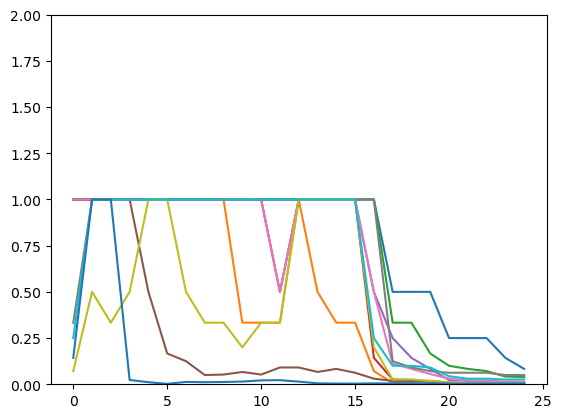

In [16]:
# Plot the results
plt.ylim([0,2])
for x in correct_token_rank_prompts:
    plt.plot(x)


In [17]:
def get_intervention_activations_diff(model, tokens, layer):
    model.reset_hooks()

    _, control_cache = model.run_with_cache(tokens)

    # Adding the function vector to residual stream
    def FV_Hook(resid_pre, hook):
        resid_pre[:, -1, :] += FV
        return resid_pre

    # Adding hook to model
    model.add_hook(f"blocks.{layer}.hook_resid_pre", FV_Hook)

    # Run model with intervention 
    logits, interv_cache = model.run_with_cache(tokens)

    diffs = []
    labels = []

    # Iterate cache
    for i in control_cache.keys():
        # Check Attention and MLP outputs
        if 'hook_attn_out' in i or 'hook_mlp_out' in i:
            # Calculate norm of difffernece vectir
            diffs.append((control_cache[i][0,-1] - interv_cache[i][0,-1]).norm().item())
            labels.append(i)

    return diffs, labels, interv_cache, control_cache  


# Check Activation Differences

In [ ]:
def direct_effect():
    

### Value of answer logit across different layers at last token pos

In [138]:
# Select which prompt
prompt_num = 8

# Get tokens from prompt and first layer of intervention
prompt_dict = zero_s_cases[prompt_num]
tks = prompt_dict['tokens']
answer_tk = prompt_dict['answer_tk']
layer = prompt_dict['layers'][0]

diffs, labels, interv_cache, control_cache = get_intervention_activations_diff(model, tks, layer)

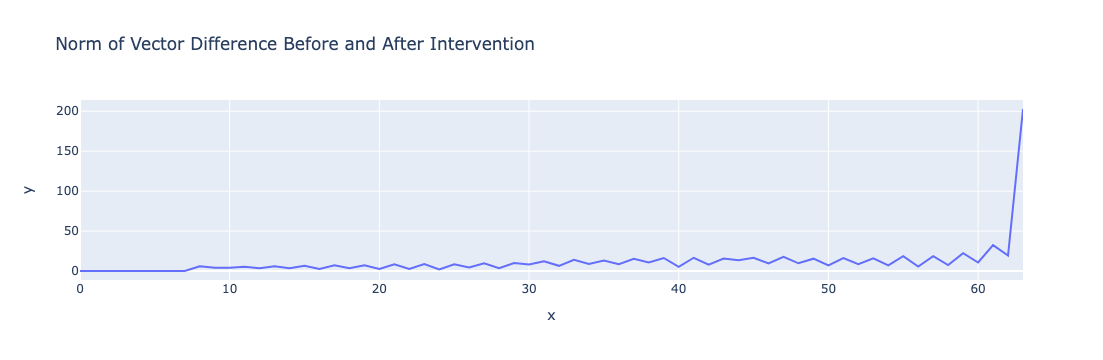

In [28]:
line(diffs, hover_name=labels[:-1], title="Norm of Vector Difference Before and After Intervention")

### Accumulated Residual Stream Analysis

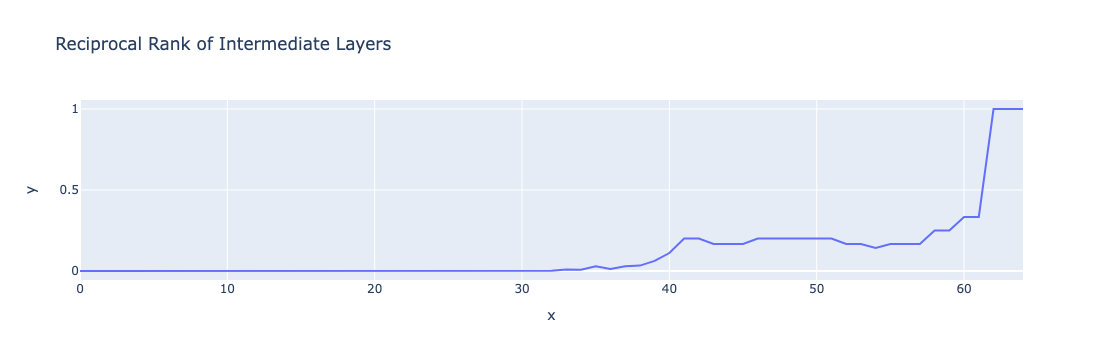

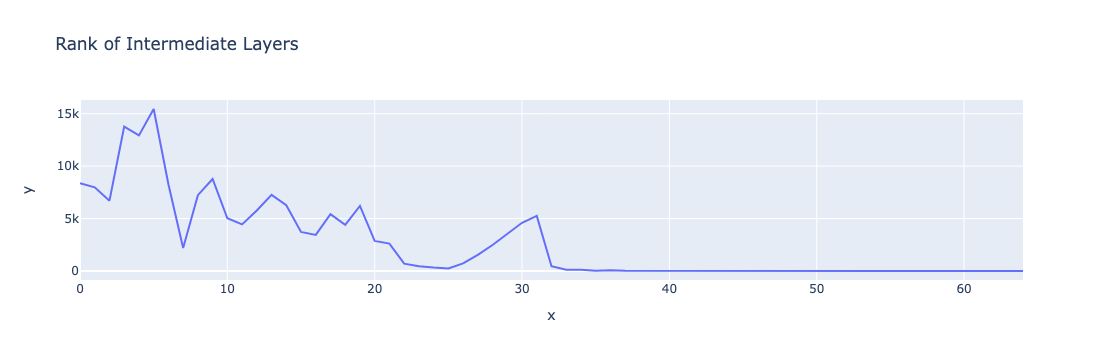

In [31]:
#Project each layer residual at last token onto vocab space
accumulated_residual, labels = interv_cache.accumulated_resid(
    layer=-1, incl_mid=True, return_labels=True, apply_ln=True
)

projection_vocab_acc = vocab_project(accumulated_residual[:,0,-1], model, True)
rank = torch.where(projection_vocab_acc.sort(-1, descending=True).indices==answer_tk)[1].cpu()
rr = 1/(rank+1)

control_accumulated_residual = control_cache.accumulated_resid(
    layer=-1, incl_mid=True, return_labels=False, apply_ln=True
)

control_projection_vocab_acc = vocab_project(control_accumulated_residual[:,0,-1], model, True)
control_rank = torch.where(control_projection_vocab_acc.sort(-1, descending=True).indices==answer_tk)[1].cpu()
control_rr = 1/(control_rank+1)


line(rr, hover_name=labels, title="Reciprocal Rank of Intermediate Layers")

line(rank, hover_name=labels, title="Rank of Intermediate Layers")


In [32]:
# Print the evolution of the resiudal stream

for i, x in enumerate(model.to_str_tokens(projection_vocab_acc.argmax(dim=1))):
    if i == layer*2:
        print("INTERVENTION HERE")
    print(labels[i], i, "TOP TOKEN: " + x, "ANSWER RANK: "+ str(rank[i].item()))

0_pre 0 TOP TOKEN: Portail ANSWER RANK: 8367
0_mid 1 TOP TOKEN: Архив ANSWER RANK: 7974
1_pre 2 TOP TOKEN: Архив ANSWER RANK: 6708
1_mid 3 TOP TOKEN: <s> ANSWER RANK: 13763
2_pre 4 TOP TOKEN: <s> ANSWER RANK: 12931
2_mid 5 TOP TOKEN: Bedeut ANSWER RANK: 15448
3_pre 6 TOP TOKEN: Bedeut ANSWER RANK: 8269
3_mid 7 TOP TOKEN: Bedeut ANSWER RANK: 2194
INTERVENTION HERE
4_pre 8 TOP TOKEN: ↔ ANSWER RANK: 7231
4_mid 9 TOP TOKEN: ↔ ANSWER RANK: 8776
5_pre 10 TOP TOKEN: ↔ ANSWER RANK: 5032
5_mid 11 TOP TOKEN: ↔ ANSWER RANK: 4439
6_pre 12 TOP TOKEN: ↔ ANSWER RANK: 5763
6_mid 13 TOP TOKEN: ↔ ANSWER RANK: 7254
7_pre 14 TOP TOKEN: ↔ ANSWER RANK: 6275
7_mid 15 TOP TOKEN: ↔ ANSWER RANK: 3730
8_pre 16 TOP TOKEN: ↔ ANSWER RANK: 3439
8_mid 17 TOP TOKEN: ↔ ANSWER RANK: 5428
9_pre 18 TOP TOKEN: ↔ ANSWER RANK: 4402
9_mid 19 TOP TOKEN: ↔ ANSWER RANK: 6209
10_pre 20 TOP TOKEN: <s> ANSWER RANK: 2872
10_mid 21 TOP TOKEN: <s> ANSWER RANK: 2610
11_pre 22 TOP TOKEN: <s> ANSWER RANK: 698
11_mid 23 TOP TOKEN: <s> ANS

### Individual Component Contribution Analysis

torch.Size([1, 7, 32000])


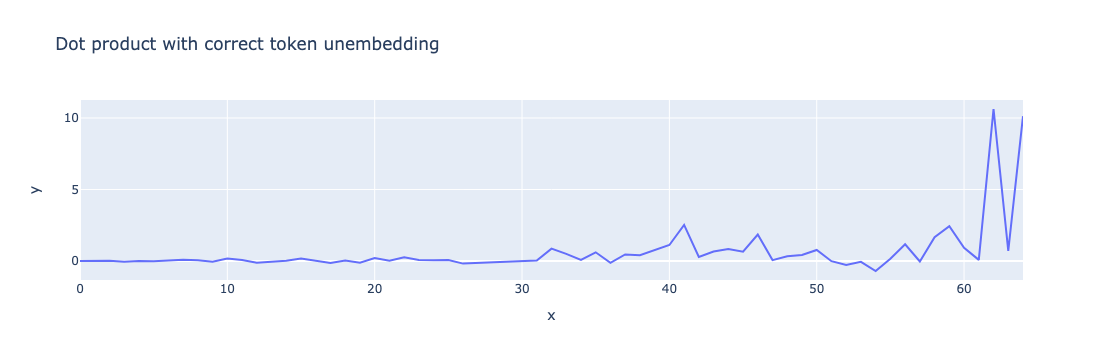

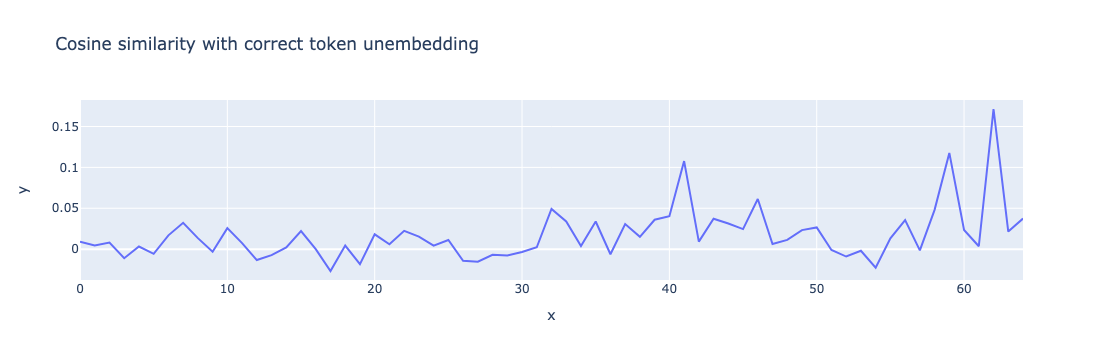

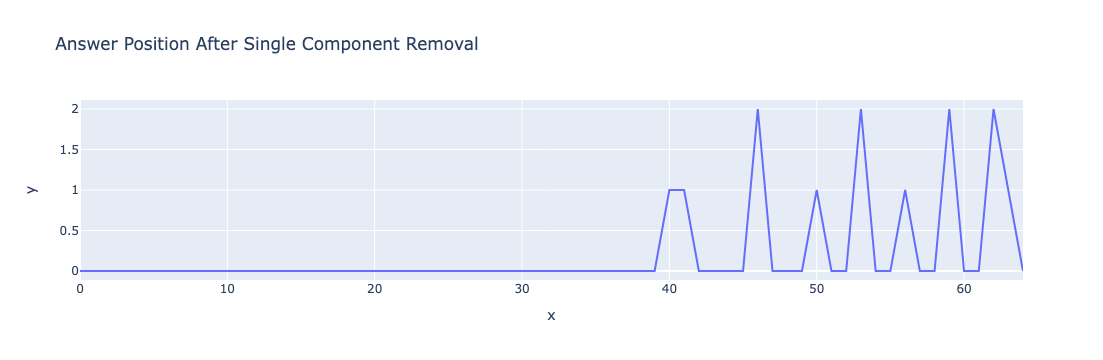

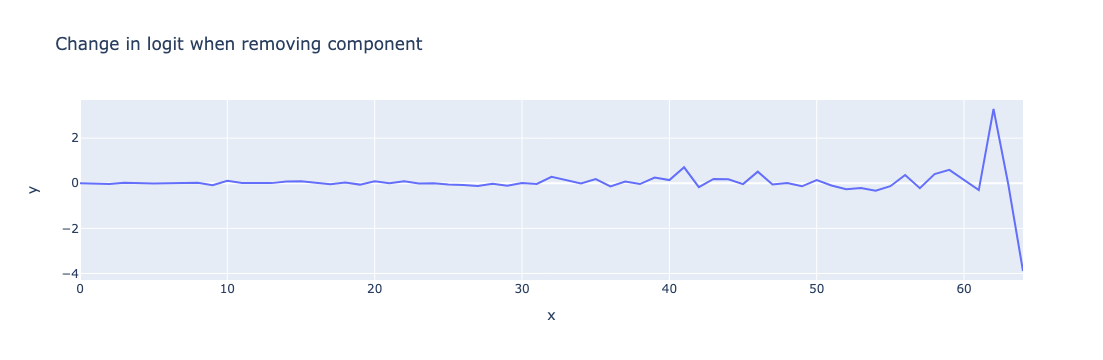

In [86]:
# Get each component contribution
per_component_residual, decomp_labels = interv_cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)

# Get Dot Product with Answer Embedding
dots_vocab = einsum("layer d_model, d_model --> layer", per_component_residual[:,-1,:], model.W_U[:,answer_tk])

# Get Cosine Sim
mult_norms = per_component_residual[:,-1,:].norm(dim=-1) * model.W_U[:,answer_tk].norm()
cos_vocab = dots_vocab/ mult_norms

# Perform direct effect on logit and rank calculation
# Get previous logit 
final = interv_cache['blocks.31.hook_resid_post'][0,-1].detach().clone()
prev_logits = model.unembed(model.ln_final(interv_cache['blocks.31.hook_resid_post'].detach().clone()))
print(prev_logits.shape)
correct_pos = []
logit_diff = []

for component in per_component_residual:
    final = interv_cache['blocks.31.hook_resid_post'][0,-1].detach().clone()
    final -= component[0]
    vocab_dist = vocab_project(model.ln_final(final), model)
    logit_diff.append(prev_logits[0,-1,answer_tk].cpu().item() - vocab_dist[answer_tk].cpu().item())
    pos = torch.where(vocab_dist.sort(descending=True).indices == answer_tk)[0].item()
    correct_pos.append(pos)
    

line(dots_vocab.cpu().numpy(), hover_name=decomp_labels, title="Dot product with correct token unembedding")
line(cos_vocab.cpu().numpy(), hover_name=decomp_labels, title="Cosine similarity with correct token unembedding")
line(correct_pos, hover_name=decomp_labels, title="Answer Position After Single Component Removal")
line(logit_diff, hover_name=decomp_labels, title="Change in logit when removing component")



### Removing these key components all together

In [87]:
component_list = [40,41,46, 50, 56, 58, 59, 62]
final = interv_cache['blocks.31.hook_resid_post'][0,-1].detach().clone()

for i in component_list:
    final -= per_component_residual[i][0]
vocab_dist = vocab_project(model.ln_final(final), model)
print(torch.where(vocab_dist.sort(descending=True).indices == answer_tk)[0].item())

89


# Head Analysis

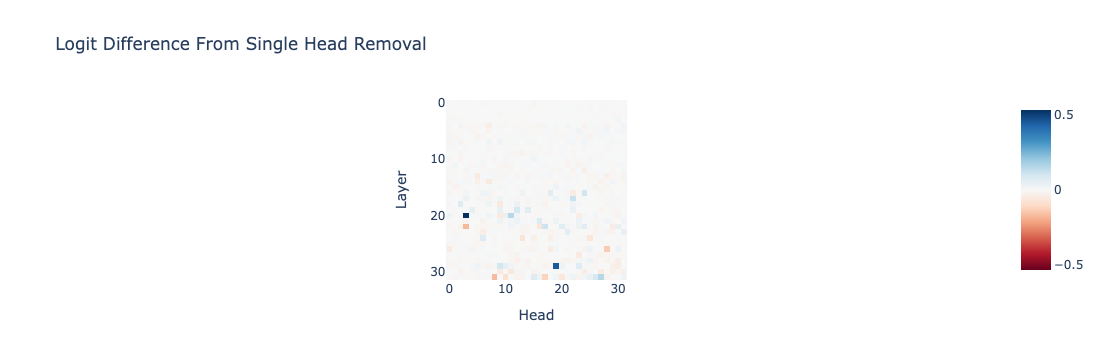

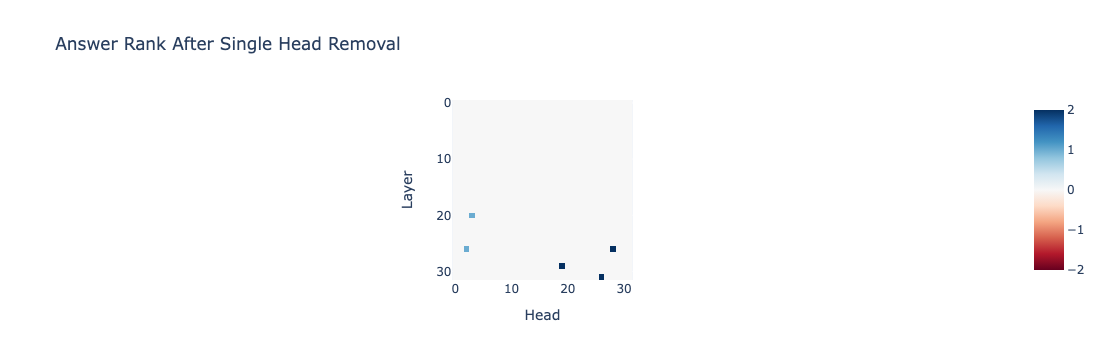

In [103]:
# Get head residuals
per_head_residual, labels = interv_cache.stack_head_results(
    layer=-1, pos_slice=-1, apply_ln=True, return_labels=True
)

head_logit_diff = []
head_correct_pos = []
prev_logits = model.unembed(model.ln_final(interv_cache['blocks.31.hook_resid_post'].detach().clone()))

# Iterate through each head
for component in per_head_residual:
    # Get final Resid
    final = interv_cache['blocks.31.hook_resid_post'][0,-1].detach().clone()

    # Remove component contribution
    final -= component[0]

    # Get new logits
    vocab_dist = vocab_project(model.ln_final(final), model)

    # Get logit diff and new rank
    head_logit_diff.append(prev_logits[0,-1,answer_tk].cpu().item() - vocab_dist[answer_tk].cpu().item())
    pos = torch.where(vocab_dist.sort(descending=True).indices == answer_tk)[0].item()
    head_correct_pos.append(pos)

# Convert to tensors
per_head_impact = torch.tensor(head_logit_diff)
per_head_rank = torch.tensor(head_correct_pos)

# Get top heads
top_heads = per_head_impact.topk(10).indices

# Rearrange diffs for plotting
per_head_impact = einops.rearrange(
    per_head_impact,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)

# Rearrange ranks for plotting
per_head_rank = einops.rearrange(
    per_head_rank,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)

# Plot diffs
imshow(
    per_head_impact,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Single Head Removal",
)

# Plot ranks
imshow(
    per_head_rank,
    labels={"x": "Head", "y": "Layer"},
    title="Answer Rank After Single Head Removal",
)

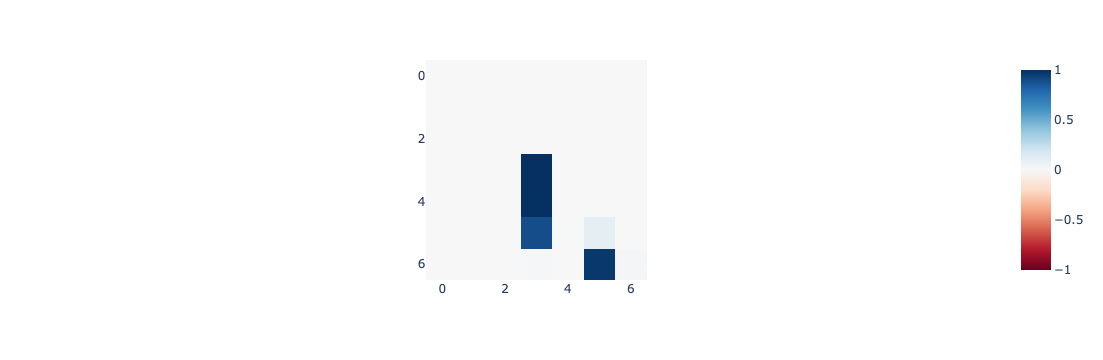

Layer 20, Head 3
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


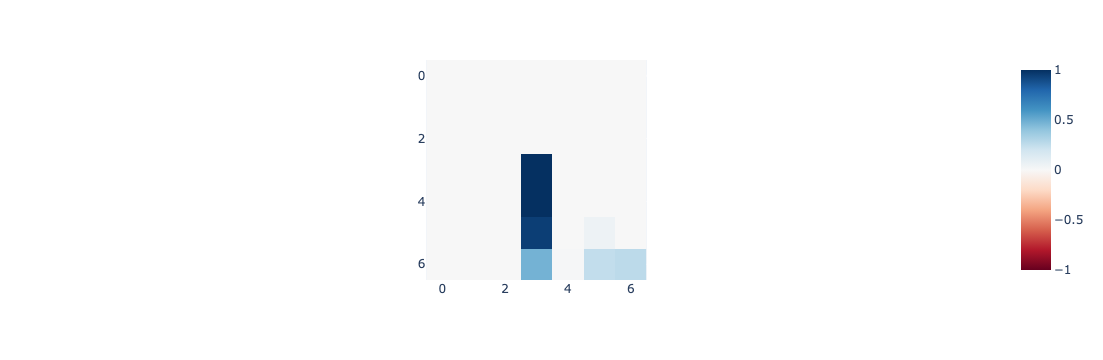

Layer 29, Head 19
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


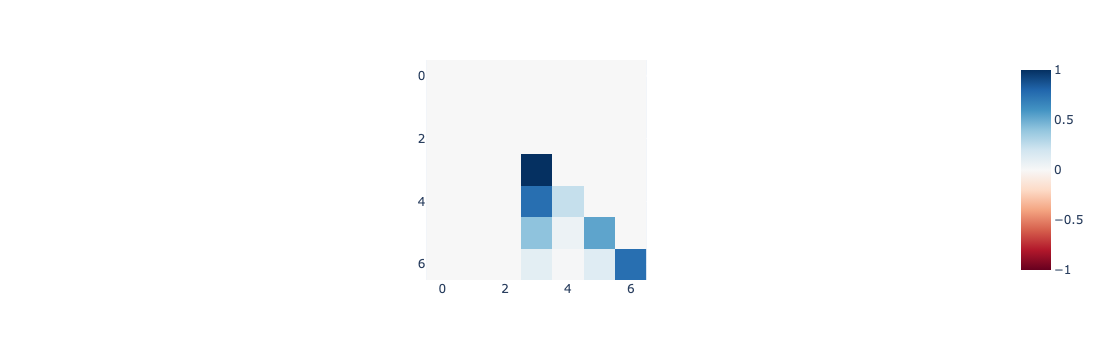

Layer 31, Head 27
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


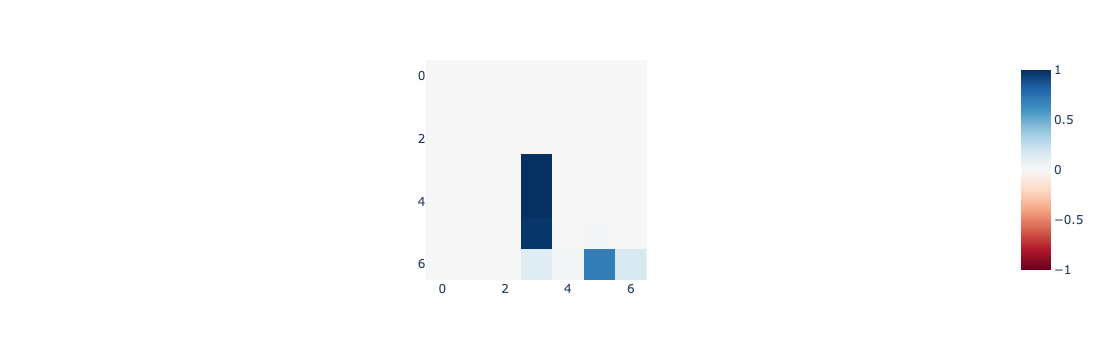

Layer 20, Head 11
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


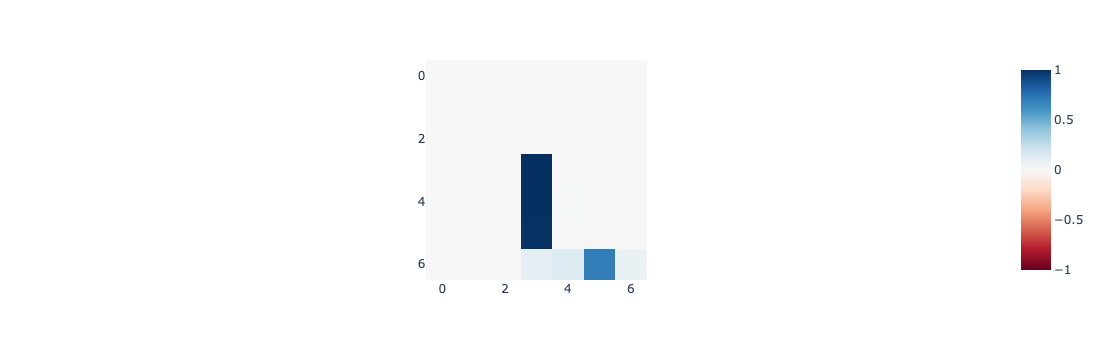

Layer 17, Head 22
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


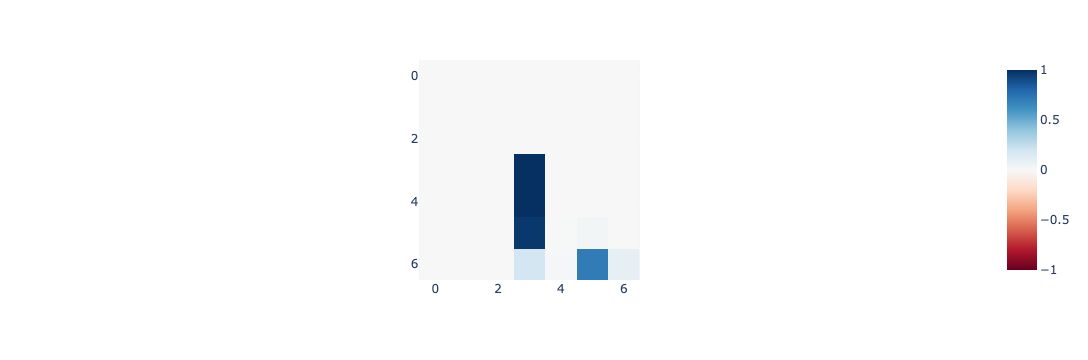

Layer 22, Head 17
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


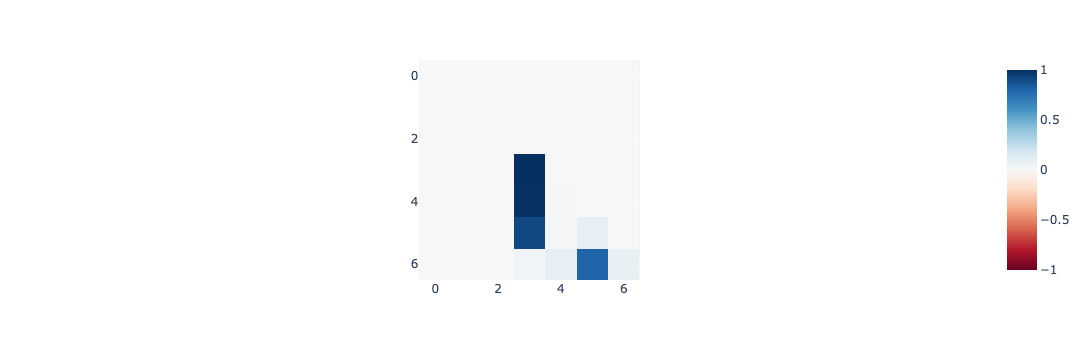

Layer 16, Head 24
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


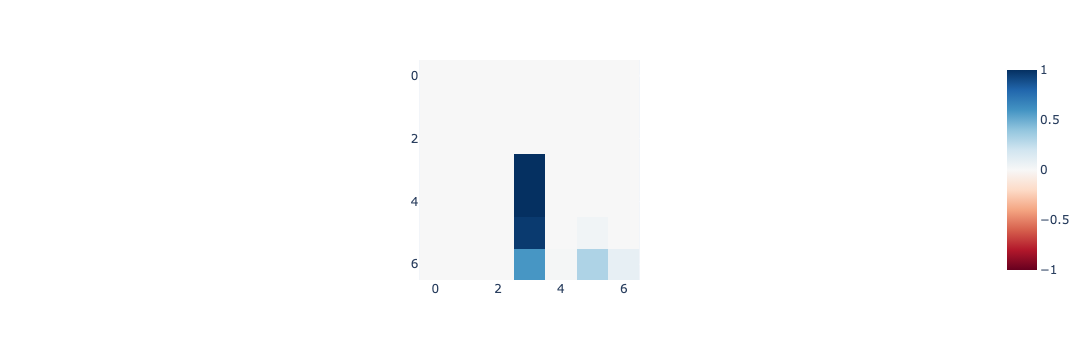

Layer 29, Head 9
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


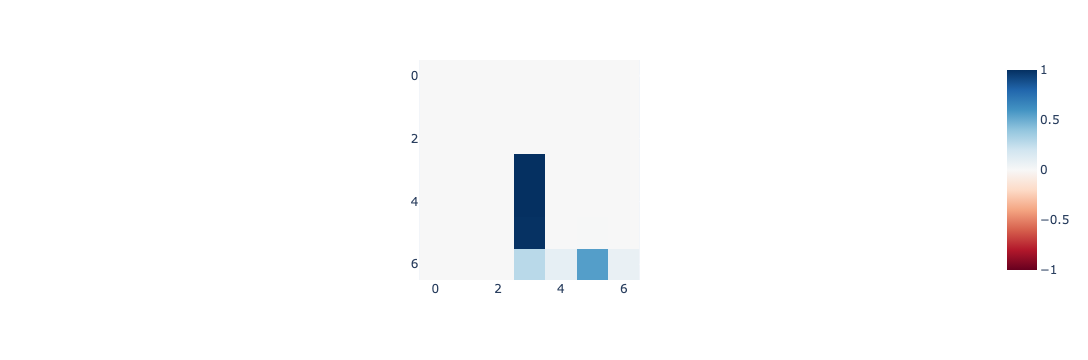

Layer 19, Head 12
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


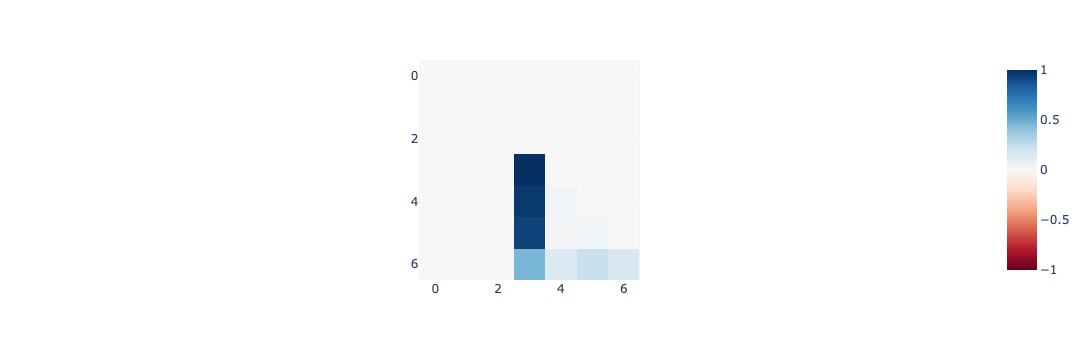

Layer 31, Head 26
['</s>', '</s>', '</s>', '</s>', '<s>', 'uncle', ':']


In [104]:
for i in range(10):
    layer = top_heads[i]//model.cfg.n_heads
    index = top_heads[i]%model.cfg.n_heads
    imshow(interv_cache[f'blocks.{layer}.attn.hook_pattern'][0][index])
    labels={"x": "Head", "y": "Layer"}
    print(f"Layer {layer}, Head {index}")
    print(model.to_str_tokens(zero_shot_tokens[prompt_num]))

In [119]:
# Decode head outputs
for i in range(10):
    projected_head = vocab_project(per_head_residual[top_heads[i]][0].detach(), model)
    print(model.to_str_tokens(projected_head.topk(15).indices))

['rough', 'rough', 'dirty', 'sweet', 'fair', 'clean', 'clean', 'cleaner', 'nast', 'dir', 'Dir', '清', 'rott', 'favor', 'unf']
['fine', 'fair', 'federal', 'field', 'foreign', 'field', 'cold', 'false', 'false', 'soul', 'fare', 'firm', 'function', 'functional', 'wet']
['football', 'fault', 'Football', 'fla', 'football', 'fou', 'fault', 'Fußball', 'F', 'Fou', 'FB', 'flower', 'fiel', 'футбо', 'FB']
['purposes', 'conditions', 'purpose', 'rights', 'condition', 'territory', 'intent', 'worse', 'errors', 'error', 'counts', 'total', 'Intent', 'fou', 'feeling']
['oul', 'IAL', 'uola', 'out', 'outs', 'ual', 'ial', 'wol', 'Soul', 'oun', 'aal', 'sols', 'Fou', 'ools', 'oval']
['priv', 'ver', 'white', 'ante', 'fresh', 'white', 'fra', 'un', 'све', 'bitter', 'sain', 'error', 'priv', 'URI', 'positive']
['フ', 'F', 'F', 'Ф', 'oul', 'fjär', 'Fou', 'fra', 'FR', 'O', 'Ф', 'Frame', 'фо', 'Fu', 'für']
['F', 'Ф', 'F', 'FF', 'Ф', 'Santa', 'Fi', 'FS', 'fos', 'FP', 'FX', 'Crow', 'CF', 'Фо', 'Fou']
['Kontrola', 'ittest

In [123]:
for attn_layer in [20,29]:
    full_attention_layer_output = per_component_residual[(attn_layer*2) + 1, 0]
    print(model.to_str_tokens(vocab_project(full_attention_layer_output, model).topk(10).indices))

['fou', 'clean', 'fair', 'clean', 'Fou', 'cleaner', 'rough', 'Fair', 'dirty', '清']
['F', 'fair', 'Ф', 'fine', 'Fair', 'F', 'fou', 'fos', 'Fine', 'faire']


# Looking at the top MLPs

In [163]:
# Print the prompt
print(model.to_str_tokens(tks), model.to_str_tokens(answer_tk))

# Taken from figure
top_mlp_layers = [19,22,24,27,30]

# Iterate over top contributing MLP Layers
for layer in top_mlp_layers:
    # For each layer, get the top contributing neurons
    neuron_weighted =  model.blocks[layer].mlp.W_out.detach() * interv_cache[f'blocks.{layer}.mlp.hook_post'][0,-1].expand(4096, -1).T
    neuron_contr = einsum('d_mlp d_model, d_model -> d_mlp', neuron_weighted, model.W_U[:,answer_tk])
    top_neurons = neuron_contr.topk(10).indices

    # Project the top contributing neurons onto the vocab space
    projected_val = vocab_project(model.blocks[layer].mlp.W_out[top_neurons, :].detach(), model, True)

    # Print whole layer composition (accounts for in layer superposition)
    print(f"__________Control {layer}__________")
    
    control_vocab = vocab_project(interv_cache[f'blocks.{layer}.hook_mlp_out'][0,-1], model, False)
    print(model.to_str_tokens(control_vocab.topk(10).indices))

    # Print individual neuron outputs
    print(f"__________Neurons in {layer}__________")
    for x in range(10):
        # Print the vocab projection of the top contributing neurons
        print("Neuron: ", top_neurons[x].item(), "Contribution: ", neuron_contr[top_neurons[x]].item())
        print(model.to_str_tokens(projected_val[x, :].topk(10).indices))
              

['</s>', '</s>', '</s>', '<s>', 'f', 'oul', ':'] ['fair']
__________Control 19__________
['pen', 'coup', 'aud', 'jsf', 'Category', 'yond', 'rela', 'words', 'Category', 'book']
__________Neurons in 19__________
Neuron:  9374 Contribution:  0.3111725449562073
['ض', 'blica', 'ř', 'Zum', 'Portail', 'фрон', 'Media', 'Media', 'Multimedia', 'leb']
Neuron:  10574 Contribution:  0.14321908354759216
['вания', 'abol', 'lus', 'fatal', 'aws', 'hors', 'ms', 'ights', 'ulas', 'mil']
Neuron:  1158 Contribution:  0.09286941587924957
['рем', 'Toast', 'udi', 'lay', 'hof', 'AX', 'berg', 'ECT', 'ง', 'antry']
Neuron:  6356 Contribution:  0.09003159403800964
['SSN', 'Ρ', 'blanc', 'oire', 'general', 'civile', 'gens', 'blue', 'Einzeln', 'Ћ']
Neuron:  597 Contribution:  0.07741488516330719
['reib', 'umi', 'ouwen', 'ach', 'ich', 'bash', 'sr', 'undial', 'opposition', 'Fest']
Neuron:  2787 Contribution:  0.07699136435985565
['lem', 'revers', 'undial', 'ems', 'ikon', 'adr', 'achine', 'Bres', 'ogne', 'agen']
Neuron: 

In [139]:
neuron_weighted =  einsum("d_mlp d_model, d_mlp -> d_mlp d_model" , model.blocks[31].mlp.W_out.detach(), cache['blocks.31.mlp.hook_post'][0,-1])